In [4]:

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x



In [6]:

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)



Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [7]:

### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)



In [8]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [9]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   



	 partial train loss (single batch): 0.253406
	 partial train loss (single batch): 0.245886
	 partial train loss (single batch): 0.240675
	 partial train loss (single batch): 0.235900
	 partial train loss (single batch): 0.231889
	 partial train loss (single batch): 0.228352
	 partial train loss (single batch): 0.225411
	 partial train loss (single batch): 0.222318
	 partial train loss (single batch): 0.220552
	 partial train loss (single batch): 0.217457
	 partial train loss (single batch): 0.215577
	 partial train loss (single batch): 0.213773
	 partial train loss (single batch): 0.211388
	 partial train loss (single batch): 0.209478
	 partial train loss (single batch): 0.207858
	 partial train loss (single batch): 0.204957
	 partial train loss (single batch): 0.203360
	 partial train loss (single batch): 0.201586
	 partial train loss (single batch): 0.198873
	 partial train loss (single batch): 0.197599
	 partial train loss (single batch): 0.195688
	 partial train loss (single batch

	 partial train loss (single batch): 0.068847
	 partial train loss (single batch): 0.067888
	 partial train loss (single batch): 0.067544
	 partial train loss (single batch): 0.066824
	 partial train loss (single batch): 0.068291
	 partial train loss (single batch): 0.066160
	 partial train loss (single batch): 0.066179
	 partial train loss (single batch): 0.066531
	 partial train loss (single batch): 0.065886

 EPOCH 1/30 	 train loss 0.12286482751369476 	 val loss 0.06556256115436554


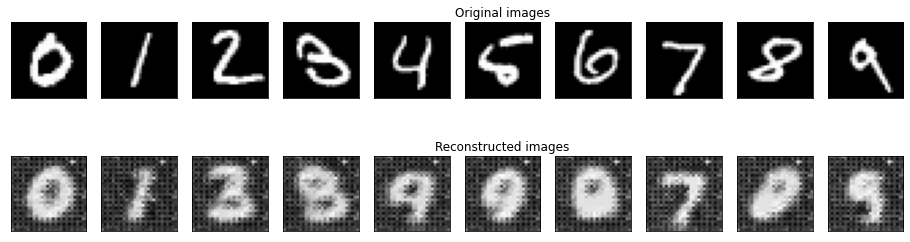

	 partial train loss (single batch): 0.065901
	 partial train loss (single batch): 0.066465
	 partial train loss (single batch): 0.065457
	 partial train loss (single batch): 0.064950
	 partial train loss (single batch): 0.064580
	 partial train loss (single batch): 0.064816
	 partial train loss (single batch): 0.064798
	 partial train loss (single batch): 0.063846
	 partial train loss (single batch): 0.063407
	 partial train loss (single batch): 0.065108
	 partial train loss (single batch): 0.064496
	 partial train loss (single batch): 0.063185
	 partial train loss (single batch): 0.063953
	 partial train loss (single batch): 0.064074
	 partial train loss (single batch): 0.062751
	 partial train loss (single batch): 0.063418
	 partial train loss (single batch): 0.062496
	 partial train loss (single batch): 0.061913
	 partial train loss (single batch): 0.063720
	 partial train loss (single batch): 0.062866
	 partial train loss (single batch): 0.061530
	 partial train loss (single batch

	 partial train loss (single batch): 0.046955
	 partial train loss (single batch): 0.047270
	 partial train loss (single batch): 0.046503
	 partial train loss (single batch): 0.048559
	 partial train loss (single batch): 0.046386
	 partial train loss (single batch): 0.046124
	 partial train loss (single batch): 0.047144
	 partial train loss (single batch): 0.046517

 EPOCH 2/30 	 train loss 0.05419069528579712 	 val loss 0.04727891832590103


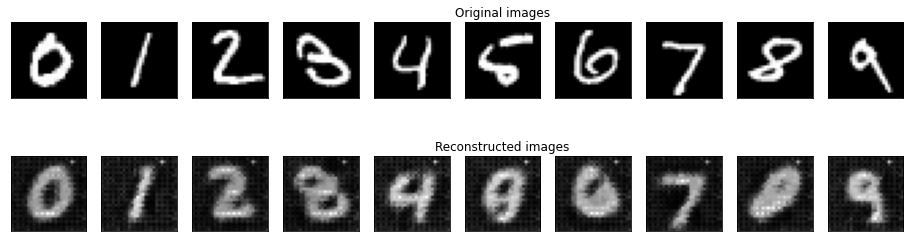

	 partial train loss (single batch): 0.046512
	 partial train loss (single batch): 0.047219
	 partial train loss (single batch): 0.046399
	 partial train loss (single batch): 0.046711
	 partial train loss (single batch): 0.046215
	 partial train loss (single batch): 0.046341
	 partial train loss (single batch): 0.047136
	 partial train loss (single batch): 0.046044
	 partial train loss (single batch): 0.045264
	 partial train loss (single batch): 0.047704
	 partial train loss (single batch): 0.047296
	 partial train loss (single batch): 0.045620
	 partial train loss (single batch): 0.046719
	 partial train loss (single batch): 0.046942
	 partial train loss (single batch): 0.045377
	 partial train loss (single batch): 0.046667
	 partial train loss (single batch): 0.045715
	 partial train loss (single batch): 0.045114
	 partial train loss (single batch): 0.047724
	 partial train loss (single batch): 0.046701
	 partial train loss (single batch): 0.045224
	 partial train loss (single batch

	 partial train loss (single batch): 0.038514
	 partial train loss (single batch): 0.037010
	 partial train loss (single batch): 0.037772
	 partial train loss (single batch): 0.037463
	 partial train loss (single batch): 0.039100
	 partial train loss (single batch): 0.037180
	 partial train loss (single batch): 0.036809
	 partial train loss (single batch): 0.037563
	 partial train loss (single batch): 0.037329

 EPOCH 3/30 	 train loss 0.0419425405561924 	 val loss 0.03780002519488335


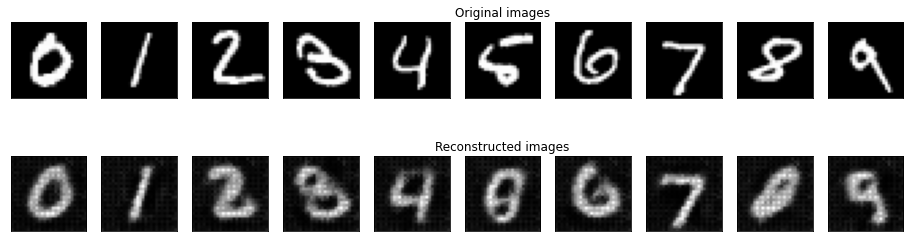

	 partial train loss (single batch): 0.037166
	 partial train loss (single batch): 0.037520
	 partial train loss (single batch): 0.037101
	 partial train loss (single batch): 0.037796
	 partial train loss (single batch): 0.036932
	 partial train loss (single batch): 0.037239
	 partial train loss (single batch): 0.038292
	 partial train loss (single batch): 0.037023
	 partial train loss (single batch): 0.036150
	 partial train loss (single batch): 0.038835
	 partial train loss (single batch): 0.037872
	 partial train loss (single batch): 0.036494
	 partial train loss (single batch): 0.037477
	 partial train loss (single batch): 0.037702
	 partial train loss (single batch): 0.035843
	 partial train loss (single batch): 0.037435
	 partial train loss (single batch): 0.035875
	 partial train loss (single batch): 0.036350
	 partial train loss (single batch): 0.039199
	 partial train loss (single batch): 0.037490
	 partial train loss (single batch): 0.036635
	 partial train loss (single batch

	 partial train loss (single batch): 0.032054
	 partial train loss (single batch): 0.033283
	 partial train loss (single batch): 0.033042
	 partial train loss (single batch): 0.034680
	 partial train loss (single batch): 0.032792
	 partial train loss (single batch): 0.032368
	 partial train loss (single batch): 0.033065
	 partial train loss (single batch): 0.032763

 EPOCH 4/30 	 train loss 0.03516736626625061 	 val loss 0.03325827792286873


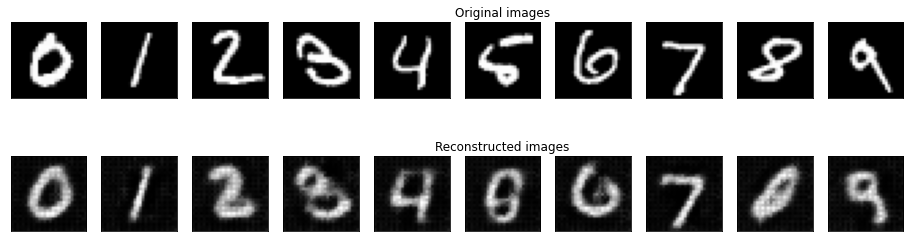

	 partial train loss (single batch): 0.032543
	 partial train loss (single batch): 0.033175
	 partial train loss (single batch): 0.032898
	 partial train loss (single batch): 0.033711
	 partial train loss (single batch): 0.032439
	 partial train loss (single batch): 0.033061
	 partial train loss (single batch): 0.034371
	 partial train loss (single batch): 0.032883
	 partial train loss (single batch): 0.031984
	 partial train loss (single batch): 0.034686
	 partial train loss (single batch): 0.033665
	 partial train loss (single batch): 0.032536
	 partial train loss (single batch): 0.033351
	 partial train loss (single batch): 0.033551
	 partial train loss (single batch): 0.031431
	 partial train loss (single batch): 0.033210
	 partial train loss (single batch): 0.031750
	 partial train loss (single batch): 0.032136
	 partial train loss (single batch): 0.035636
	 partial train loss (single batch): 0.033167
	 partial train loss (single batch): 0.032572
	 partial train loss (single batch

	 partial train loss (single batch): 0.032291
	 partial train loss (single batch): 0.031707
	 partial train loss (single batch): 0.029973
	 partial train loss (single batch): 0.031268
	 partial train loss (single batch): 0.031116
	 partial train loss (single batch): 0.032886
	 partial train loss (single batch): 0.030867
	 partial train loss (single batch): 0.030453
	 partial train loss (single batch): 0.031018
	 partial train loss (single batch): 0.030629

 EPOCH 5/30 	 train loss 0.032255228608846664 	 val loss 0.03135787695646286


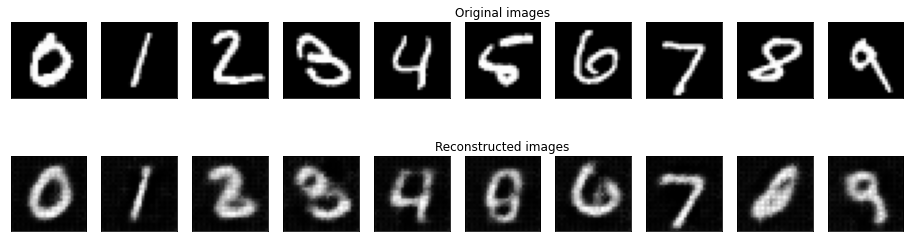

	 partial train loss (single batch): 0.030628
	 partial train loss (single batch): 0.031336
	 partial train loss (single batch): 0.031050
	 partial train loss (single batch): 0.031988
	 partial train loss (single batch): 0.030536
	 partial train loss (single batch): 0.031103
	 partial train loss (single batch): 0.032482
	 partial train loss (single batch): 0.030980
	 partial train loss (single batch): 0.029989
	 partial train loss (single batch): 0.032824
	 partial train loss (single batch): 0.031853
	 partial train loss (single batch): 0.030625
	 partial train loss (single batch): 0.031400
	 partial train loss (single batch): 0.031613
	 partial train loss (single batch): 0.029529
	 partial train loss (single batch): 0.031313
	 partial train loss (single batch): 0.030015
	 partial train loss (single batch): 0.030331
	 partial train loss (single batch): 0.033778
	 partial train loss (single batch): 0.031258
	 partial train loss (single batch): 0.030705
	 partial train loss (single batch

	 partial train loss (single batch): 0.028747
	 partial train loss (single batch): 0.030186
	 partial train loss (single batch): 0.030015
	 partial train loss (single batch): 0.031740
	 partial train loss (single batch): 0.029785
	 partial train loss (single batch): 0.029366
	 partial train loss (single batch): 0.029942
	 partial train loss (single batch): 0.029190

 EPOCH 6/30 	 train loss 0.030783262103796005 	 val loss 0.03035338595509529


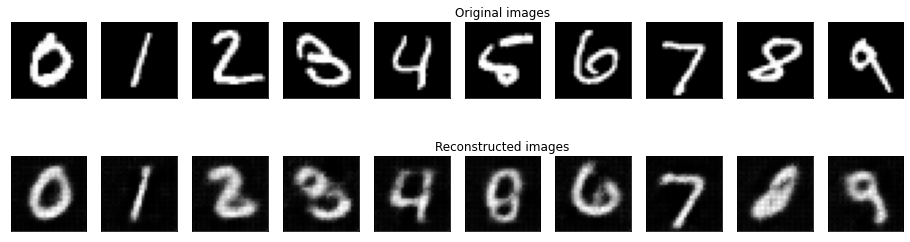

	 partial train loss (single batch): 0.029568
	 partial train loss (single batch): 0.030213
	 partial train loss (single batch): 0.030032
	 partial train loss (single batch): 0.031104
	 partial train loss (single batch): 0.029319
	 partial train loss (single batch): 0.030041
	 partial train loss (single batch): 0.031483
	 partial train loss (single batch): 0.029761
	 partial train loss (single batch): 0.028921
	 partial train loss (single batch): 0.031717
	 partial train loss (single batch): 0.030539
	 partial train loss (single batch): 0.029548
	 partial train loss (single batch): 0.030320
	 partial train loss (single batch): 0.030468
	 partial train loss (single batch): 0.028464
	 partial train loss (single batch): 0.030202
	 partial train loss (single batch): 0.028900
	 partial train loss (single batch): 0.029133
	 partial train loss (single batch): 0.032807
	 partial train loss (single batch): 0.030066
	 partial train loss (single batch): 0.029622
	 partial train loss (single batch

	 partial train loss (single batch): 0.029962
	 partial train loss (single batch): 0.027991
	 partial train loss (single batch): 0.029489
	 partial train loss (single batch): 0.029265
	 partial train loss (single batch): 0.030926
	 partial train loss (single batch): 0.029024
	 partial train loss (single batch): 0.028594
	 partial train loss (single batch): 0.029202
	 partial train loss (single batch): 0.028365

 EPOCH 7/30 	 train loss 0.029860440641641617 	 val loss 0.02959415689110756


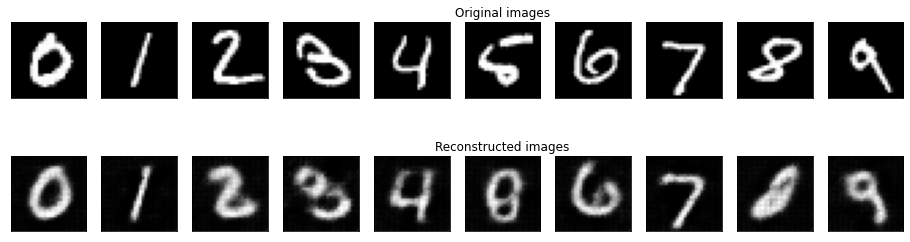

	 partial train loss (single batch): 0.028712
	 partial train loss (single batch): 0.029387
	 partial train loss (single batch): 0.029254
	 partial train loss (single batch): 0.030335
	 partial train loss (single batch): 0.028717
	 partial train loss (single batch): 0.029295
	 partial train loss (single batch): 0.030752
	 partial train loss (single batch): 0.028909
	 partial train loss (single batch): 0.027966
	 partial train loss (single batch): 0.031037
	 partial train loss (single batch): 0.029756
	 partial train loss (single batch): 0.028717
	 partial train loss (single batch): 0.029612
	 partial train loss (single batch): 0.029791
	 partial train loss (single batch): 0.027774
	 partial train loss (single batch): 0.029511
	 partial train loss (single batch): 0.028138
	 partial train loss (single batch): 0.028349
	 partial train loss (single batch): 0.032159
	 partial train loss (single batch): 0.029297
	 partial train loss (single batch): 0.028924
	 partial train loss (single batch

	 partial train loss (single batch): 0.027486
	 partial train loss (single batch): 0.029103
	 partial train loss (single batch): 0.028771
	 partial train loss (single batch): 0.030383
	 partial train loss (single batch): 0.028538
	 partial train loss (single batch): 0.028227
	 partial train loss (single batch): 0.028710
	 partial train loss (single batch): 0.027837

 EPOCH 8/30 	 train loss 0.02924135886132717 	 val loss 0.029075751081109047


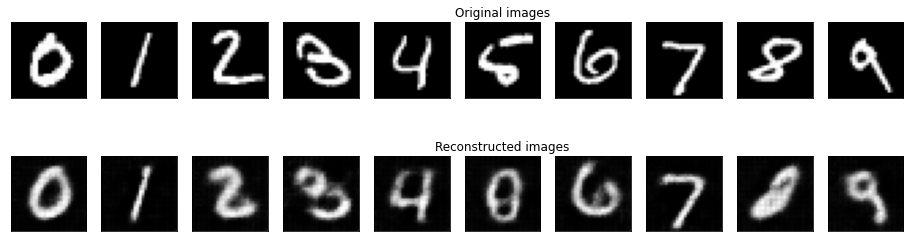

	 partial train loss (single batch): 0.028185
	 partial train loss (single batch): 0.028803
	 partial train loss (single batch): 0.028706
	 partial train loss (single batch): 0.029617
	 partial train loss (single batch): 0.028256
	 partial train loss (single batch): 0.028746
	 partial train loss (single batch): 0.030138
	 partial train loss (single batch): 0.028295
	 partial train loss (single batch): 0.027378
	 partial train loss (single batch): 0.030613
	 partial train loss (single batch): 0.029179
	 partial train loss (single batch): 0.028220
	 partial train loss (single batch): 0.029008
	 partial train loss (single batch): 0.029202
	 partial train loss (single batch): 0.027177
	 partial train loss (single batch): 0.029007
	 partial train loss (single batch): 0.027550
	 partial train loss (single batch): 0.027887
	 partial train loss (single batch): 0.031588
	 partial train loss (single batch): 0.028862
	 partial train loss (single batch): 0.028288
	 partial train loss (single batch

	 partial train loss (single batch): 0.027132
	 partial train loss (single batch): 0.028795
	 partial train loss (single batch): 0.028339
	 partial train loss (single batch): 0.029978
	 partial train loss (single batch): 0.028147
	 partial train loss (single batch): 0.027899
	 partial train loss (single batch): 0.028228
	 partial train loss (single batch): 0.027325

 EPOCH 9/30 	 train loss 0.028771882876753807 	 val loss 0.02872980386018753


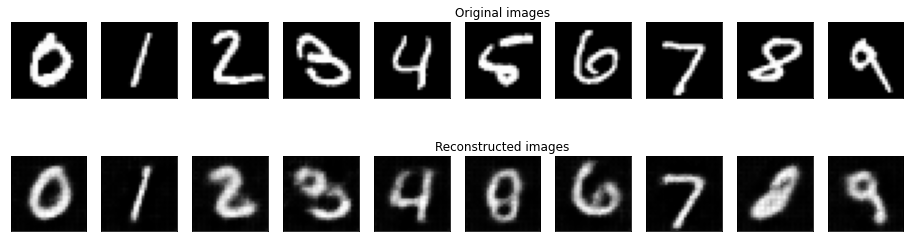

	 partial train loss (single batch): 0.027690
	 partial train loss (single batch): 0.028492
	 partial train loss (single batch): 0.028272
	 partial train loss (single batch): 0.029206
	 partial train loss (single batch): 0.027906
	 partial train loss (single batch): 0.028391
	 partial train loss (single batch): 0.029772
	 partial train loss (single batch): 0.027847
	 partial train loss (single batch): 0.026968
	 partial train loss (single batch): 0.030222
	 partial train loss (single batch): 0.028752
	 partial train loss (single batch): 0.027813
	 partial train loss (single batch): 0.028582
	 partial train loss (single batch): 0.028742
	 partial train loss (single batch): 0.026881
	 partial train loss (single batch): 0.028553
	 partial train loss (single batch): 0.027236
	 partial train loss (single batch): 0.027546
	 partial train loss (single batch): 0.031201
	 partial train loss (single batch): 0.028557
	 partial train loss (single batch): 0.027939
	 partial train loss (single batch

	 partial train loss (single batch): 0.026761
	 partial train loss (single batch): 0.028501
	 partial train loss (single batch): 0.027925
	 partial train loss (single batch): 0.029652
	 partial train loss (single batch): 0.027883
	 partial train loss (single batch): 0.027591
	 partial train loss (single batch): 0.027909
	 partial train loss (single batch): 0.026983

 EPOCH 10/30 	 train loss 0.028391093015670776 	 val loss 0.028446268290281296


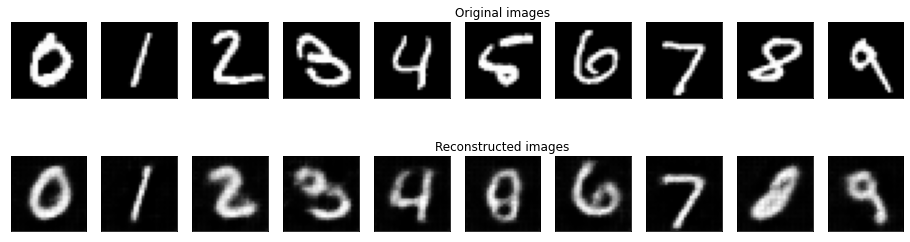

	 partial train loss (single batch): 0.027260
	 partial train loss (single batch): 0.028237
	 partial train loss (single batch): 0.027873
	 partial train loss (single batch): 0.028795
	 partial train loss (single batch): 0.027606
	 partial train loss (single batch): 0.028064
	 partial train loss (single batch): 0.029346
	 partial train loss (single batch): 0.027563
	 partial train loss (single batch): 0.026607
	 partial train loss (single batch): 0.030001
	 partial train loss (single batch): 0.028410
	 partial train loss (single batch): 0.027462
	 partial train loss (single batch): 0.028247
	 partial train loss (single batch): 0.028385
	 partial train loss (single batch): 0.026565
	 partial train loss (single batch): 0.028122
	 partial train loss (single batch): 0.026995
	 partial train loss (single batch): 0.027274
	 partial train loss (single batch): 0.030793
	 partial train loss (single batch): 0.028273
	 partial train loss (single batch): 0.027690
	 partial train loss (single batch

	 partial train loss (single batch): 0.028630
	 partial train loss (single batch): 0.026519
	 partial train loss (single batch): 0.028293
	 partial train loss (single batch): 0.027563
	 partial train loss (single batch): 0.029344
	 partial train loss (single batch): 0.027622
	 partial train loss (single batch): 0.027316
	 partial train loss (single batch): 0.027624
	 partial train loss (single batch): 0.026653

 EPOCH 11/30 	 train loss 0.028078492730855942 	 val loss 0.028144817799329758


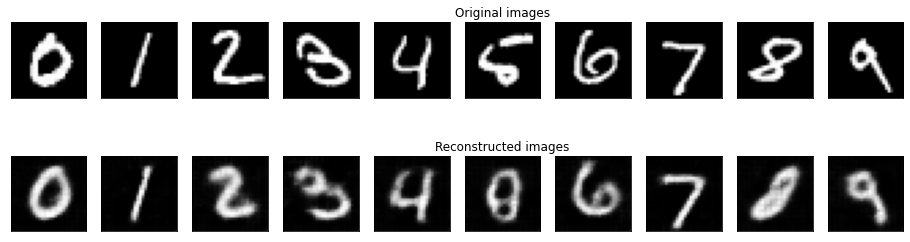

	 partial train loss (single batch): 0.026918
	 partial train loss (single batch): 0.028087
	 partial train loss (single batch): 0.027561
	 partial train loss (single batch): 0.028467
	 partial train loss (single batch): 0.027400
	 partial train loss (single batch): 0.027785
	 partial train loss (single batch): 0.029047
	 partial train loss (single batch): 0.027233
	 partial train loss (single batch): 0.026192
	 partial train loss (single batch): 0.029697
	 partial train loss (single batch): 0.028191
	 partial train loss (single batch): 0.027109
	 partial train loss (single batch): 0.027927
	 partial train loss (single batch): 0.028147
	 partial train loss (single batch): 0.026343
	 partial train loss (single batch): 0.027791
	 partial train loss (single batch): 0.026672
	 partial train loss (single batch): 0.027019
	 partial train loss (single batch): 0.030529
	 partial train loss (single batch): 0.027980
	 partial train loss (single batch): 0.027281
	 partial train loss (single batch

	 partial train loss (single batch): 0.026254
	 partial train loss (single batch): 0.028042
	 partial train loss (single batch): 0.027251
	 partial train loss (single batch): 0.029096
	 partial train loss (single batch): 0.027449
	 partial train loss (single batch): 0.027071
	 partial train loss (single batch): 0.027407
	 partial train loss (single batch): 0.026380

 EPOCH 12/30 	 train loss 0.02780093066394329 	 val loss 0.027919437736272812


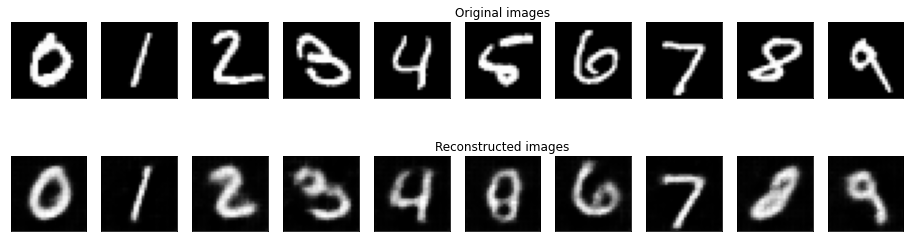

	 partial train loss (single batch): 0.026577
	 partial train loss (single batch): 0.027909
	 partial train loss (single batch): 0.027282
	 partial train loss (single batch): 0.028191
	 partial train loss (single batch): 0.027219
	 partial train loss (single batch): 0.027514
	 partial train loss (single batch): 0.028758
	 partial train loss (single batch): 0.026948
	 partial train loss (single batch): 0.025936
	 partial train loss (single batch): 0.029445
	 partial train loss (single batch): 0.027895
	 partial train loss (single batch): 0.026797
	 partial train loss (single batch): 0.027793
	 partial train loss (single batch): 0.027902
	 partial train loss (single batch): 0.026173
	 partial train loss (single batch): 0.027477
	 partial train loss (single batch): 0.026458
	 partial train loss (single batch): 0.026825
	 partial train loss (single batch): 0.030347
	 partial train loss (single batch): 0.027747
	 partial train loss (single batch): 0.026975
	 partial train loss (single batch

	 partial train loss (single batch): 0.026025
	 partial train loss (single batch): 0.027805
	 partial train loss (single batch): 0.027054
	 partial train loss (single batch): 0.028945
	 partial train loss (single batch): 0.027211
	 partial train loss (single batch): 0.026836
	 partial train loss (single batch): 0.027160
	 partial train loss (single batch): 0.026145

 EPOCH 13/30 	 train loss 0.027565956115722656 	 val loss 0.027685832232236862


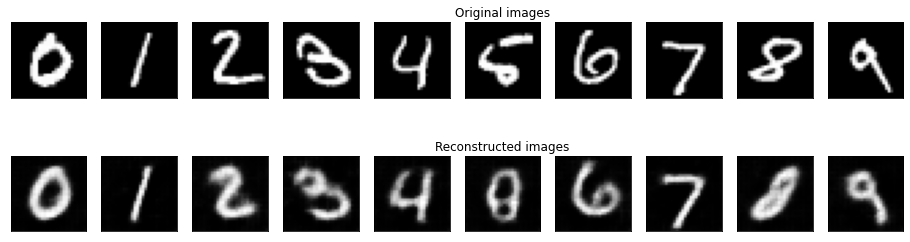

	 partial train loss (single batch): 0.026346
	 partial train loss (single batch): 0.027635
	 partial train loss (single batch): 0.027058
	 partial train loss (single batch): 0.027903
	 partial train loss (single batch): 0.026991
	 partial train loss (single batch): 0.027279
	 partial train loss (single batch): 0.028524
	 partial train loss (single batch): 0.026667
	 partial train loss (single batch): 0.025686
	 partial train loss (single batch): 0.029251
	 partial train loss (single batch): 0.027639
	 partial train loss (single batch): 0.026531
	 partial train loss (single batch): 0.027568
	 partial train loss (single batch): 0.027696
	 partial train loss (single batch): 0.025953
	 partial train loss (single batch): 0.027294
	 partial train loss (single batch): 0.026260
	 partial train loss (single batch): 0.026589
	 partial train loss (single batch): 0.030102
	 partial train loss (single batch): 0.027566
	 partial train loss (single batch): 0.026709
	 partial train loss (single batch

	 partial train loss (single batch): 0.025790
	 partial train loss (single batch): 0.027696
	 partial train loss (single batch): 0.026836
	 partial train loss (single batch): 0.028801
	 partial train loss (single batch): 0.027060
	 partial train loss (single batch): 0.026651
	 partial train loss (single batch): 0.027021
	 partial train loss (single batch): 0.025991

 EPOCH 14/30 	 train loss 0.027362851426005363 	 val loss 0.027482107281684875


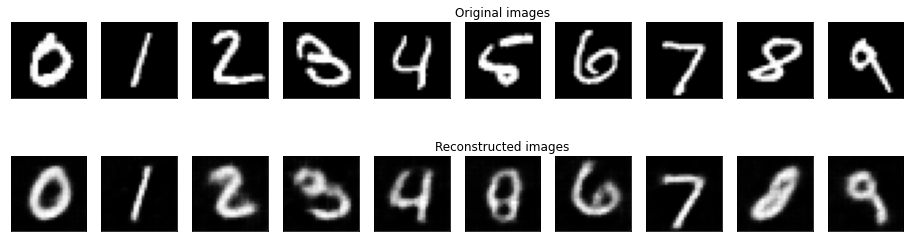

	 partial train loss (single batch): 0.026095
	 partial train loss (single batch): 0.027449
	 partial train loss (single batch): 0.026817
	 partial train loss (single batch): 0.027784
	 partial train loss (single batch): 0.026885
	 partial train loss (single batch): 0.027159
	 partial train loss (single batch): 0.028414
	 partial train loss (single batch): 0.026427
	 partial train loss (single batch): 0.025556
	 partial train loss (single batch): 0.029102
	 partial train loss (single batch): 0.027476
	 partial train loss (single batch): 0.026378
	 partial train loss (single batch): 0.027360
	 partial train loss (single batch): 0.027457
	 partial train loss (single batch): 0.025838
	 partial train loss (single batch): 0.027068
	 partial train loss (single batch): 0.026060
	 partial train loss (single batch): 0.026411
	 partial train loss (single batch): 0.029959
	 partial train loss (single batch): 0.027386
	 partial train loss (single batch): 0.026529
	 partial train loss (single batch

	 partial train loss (single batch): 0.027866
	 partial train loss (single batch): 0.025613
	 partial train loss (single batch): 0.027432
	 partial train loss (single batch): 0.026639
	 partial train loss (single batch): 0.028635
	 partial train loss (single batch): 0.026946
	 partial train loss (single batch): 0.026477
	 partial train loss (single batch): 0.026894
	 partial train loss (single batch): 0.025844

 EPOCH 15/30 	 train loss 0.027183497324585915 	 val loss 0.02737024426460266


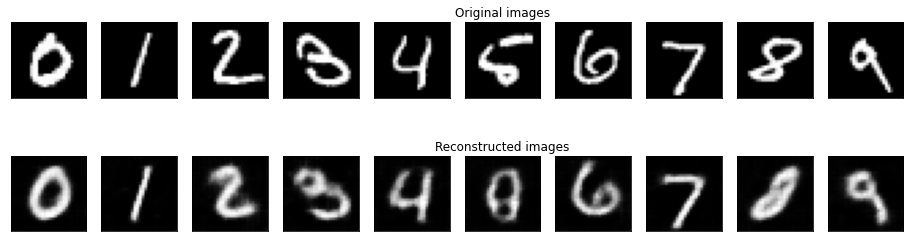

	 partial train loss (single batch): 0.025971
	 partial train loss (single batch): 0.027247
	 partial train loss (single batch): 0.026688
	 partial train loss (single batch): 0.027567
	 partial train loss (single batch): 0.026709
	 partial train loss (single batch): 0.026990
	 partial train loss (single batch): 0.028134
	 partial train loss (single batch): 0.026254
	 partial train loss (single batch): 0.025452
	 partial train loss (single batch): 0.028973
	 partial train loss (single batch): 0.027345
	 partial train loss (single batch): 0.026233
	 partial train loss (single batch): 0.027240
	 partial train loss (single batch): 0.027326
	 partial train loss (single batch): 0.025648
	 partial train loss (single batch): 0.026995
	 partial train loss (single batch): 0.025836
	 partial train loss (single batch): 0.026301
	 partial train loss (single batch): 0.029748
	 partial train loss (single batch): 0.027223
	 partial train loss (single batch): 0.026370
	 partial train loss (single batch

	 partial train loss (single batch): 0.027685
	 partial train loss (single batch): 0.025381
	 partial train loss (single batch): 0.027324
	 partial train loss (single batch): 0.026429
	 partial train loss (single batch): 0.028470
	 partial train loss (single batch): 0.026759
	 partial train loss (single batch): 0.026299
	 partial train loss (single batch): 0.026749
	 partial train loss (single batch): 0.025781

 EPOCH 16/30 	 train loss 0.02702302858233452 	 val loss 0.027254164218902588


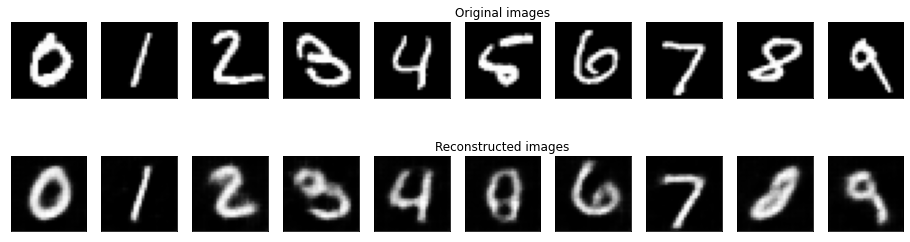

	 partial train loss (single batch): 0.025869
	 partial train loss (single batch): 0.027047
	 partial train loss (single batch): 0.026500
	 partial train loss (single batch): 0.027388
	 partial train loss (single batch): 0.026522
	 partial train loss (single batch): 0.026958
	 partial train loss (single batch): 0.028016
	 partial train loss (single batch): 0.026099
	 partial train loss (single batch): 0.025327
	 partial train loss (single batch): 0.028926
	 partial train loss (single batch): 0.027208
	 partial train loss (single batch): 0.026177
	 partial train loss (single batch): 0.027096
	 partial train loss (single batch): 0.027147
	 partial train loss (single batch): 0.025500
	 partial train loss (single batch): 0.026883
	 partial train loss (single batch): 0.025711
	 partial train loss (single batch): 0.026038
	 partial train loss (single batch): 0.029568
	 partial train loss (single batch): 0.027081
	 partial train loss (single batch): 0.026125
	 partial train loss (single batch

	 partial train loss (single batch): 0.025194
	 partial train loss (single batch): 0.027119
	 partial train loss (single batch): 0.026187
	 partial train loss (single batch): 0.028318
	 partial train loss (single batch): 0.026683
	 partial train loss (single batch): 0.026125
	 partial train loss (single batch): 0.026611
	 partial train loss (single batch): 0.025717

 EPOCH 17/30 	 train loss 0.026879610493779182 	 val loss 0.027127353474497795


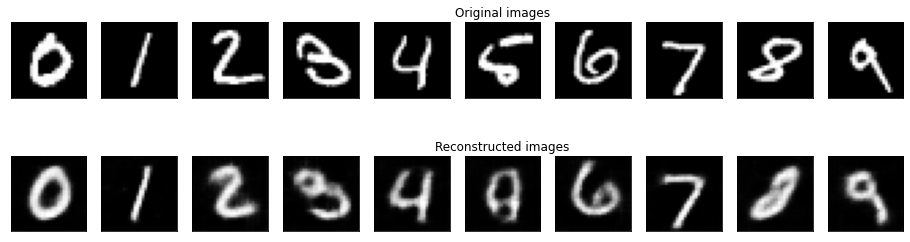

	 partial train loss (single batch): 0.025686
	 partial train loss (single batch): 0.026854
	 partial train loss (single batch): 0.026390
	 partial train loss (single batch): 0.027231
	 partial train loss (single batch): 0.026392
	 partial train loss (single batch): 0.026909
	 partial train loss (single batch): 0.027934
	 partial train loss (single batch): 0.025930
	 partial train loss (single batch): 0.025208
	 partial train loss (single batch): 0.028851
	 partial train loss (single batch): 0.026979
	 partial train loss (single batch): 0.026106
	 partial train loss (single batch): 0.026909
	 partial train loss (single batch): 0.026985
	 partial train loss (single batch): 0.025297
	 partial train loss (single batch): 0.026649
	 partial train loss (single batch): 0.025512
	 partial train loss (single batch): 0.025954
	 partial train loss (single batch): 0.029398
	 partial train loss (single batch): 0.026993
	 partial train loss (single batch): 0.026003
	 partial train loss (single batch

	 partial train loss (single batch): 0.025038
	 partial train loss (single batch): 0.026961
	 partial train loss (single batch): 0.026021
	 partial train loss (single batch): 0.028288
	 partial train loss (single batch): 0.026575
	 partial train loss (single batch): 0.025905
	 partial train loss (single batch): 0.026509
	 partial train loss (single batch): 0.025583

 EPOCH 18/30 	 train loss 0.026728874072432518 	 val loss 0.027035290375351906


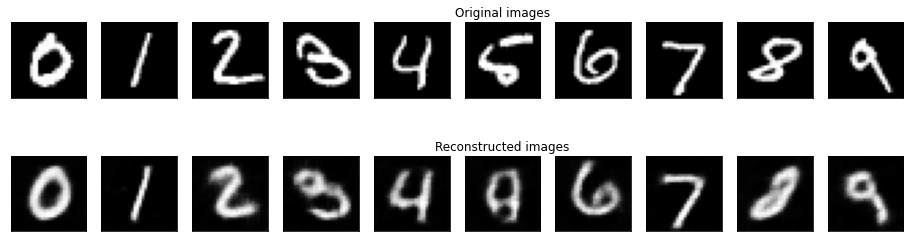

	 partial train loss (single batch): 0.025597
	 partial train loss (single batch): 0.026703
	 partial train loss (single batch): 0.026162
	 partial train loss (single batch): 0.027142
	 partial train loss (single batch): 0.026225
	 partial train loss (single batch): 0.026870
	 partial train loss (single batch): 0.027752
	 partial train loss (single batch): 0.025866
	 partial train loss (single batch): 0.025122
	 partial train loss (single batch): 0.028773
	 partial train loss (single batch): 0.026934
	 partial train loss (single batch): 0.025981
	 partial train loss (single batch): 0.026829
	 partial train loss (single batch): 0.026938
	 partial train loss (single batch): 0.025175
	 partial train loss (single batch): 0.026476
	 partial train loss (single batch): 0.025273
	 partial train loss (single batch): 0.025838
	 partial train loss (single batch): 0.029361
	 partial train loss (single batch): 0.026882
	 partial train loss (single batch): 0.025900
	 partial train loss (single batch

	 partial train loss (single batch): 0.024907
	 partial train loss (single batch): 0.026902
	 partial train loss (single batch): 0.025915
	 partial train loss (single batch): 0.028097
	 partial train loss (single batch): 0.026394
	 partial train loss (single batch): 0.025786
	 partial train loss (single batch): 0.026353
	 partial train loss (single batch): 0.025428

 EPOCH 19/30 	 train loss 0.026616623625159264 	 val loss 0.026942355558276176


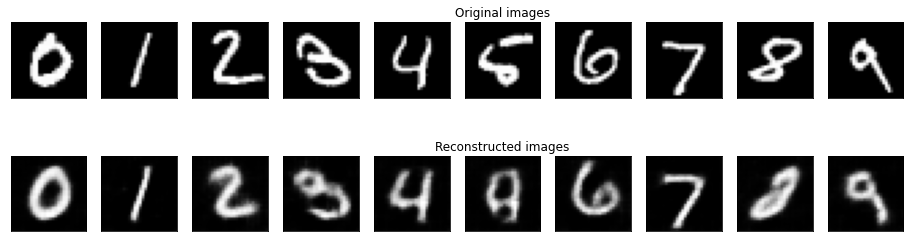

	 partial train loss (single batch): 0.025419
	 partial train loss (single batch): 0.026481
	 partial train loss (single batch): 0.026054
	 partial train loss (single batch): 0.026977
	 partial train loss (single batch): 0.026126
	 partial train loss (single batch): 0.026733
	 partial train loss (single batch): 0.027634
	 partial train loss (single batch): 0.025652
	 partial train loss (single batch): 0.024971
	 partial train loss (single batch): 0.028605
	 partial train loss (single batch): 0.026804
	 partial train loss (single batch): 0.025931
	 partial train loss (single batch): 0.026720
	 partial train loss (single batch): 0.026743
	 partial train loss (single batch): 0.025091
	 partial train loss (single batch): 0.026421
	 partial train loss (single batch): 0.025167
	 partial train loss (single batch): 0.025750
	 partial train loss (single batch): 0.029253
	 partial train loss (single batch): 0.026716
	 partial train loss (single batch): 0.025844
	 partial train loss (single batch

	 partial train loss (single batch): 0.024777
	 partial train loss (single batch): 0.026796
	 partial train loss (single batch): 0.025788
	 partial train loss (single batch): 0.027886
	 partial train loss (single batch): 0.026269
	 partial train loss (single batch): 0.025607
	 partial train loss (single batch): 0.026210
	 partial train loss (single batch): 0.025289

 EPOCH 20/30 	 train loss 0.026484396308660507 	 val loss 0.026894226670265198


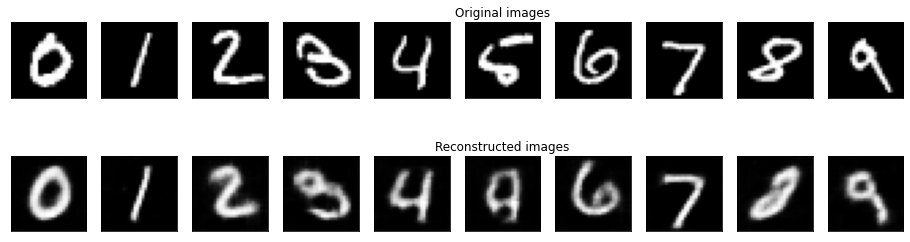

	 partial train loss (single batch): 0.025372
	 partial train loss (single batch): 0.026441
	 partial train loss (single batch): 0.025915
	 partial train loss (single batch): 0.026917
	 partial train loss (single batch): 0.025957
	 partial train loss (single batch): 0.026711
	 partial train loss (single batch): 0.027535
	 partial train loss (single batch): 0.025599
	 partial train loss (single batch): 0.024843
	 partial train loss (single batch): 0.028476
	 partial train loss (single batch): 0.026720
	 partial train loss (single batch): 0.025865
	 partial train loss (single batch): 0.026585
	 partial train loss (single batch): 0.026668
	 partial train loss (single batch): 0.024965
	 partial train loss (single batch): 0.026325
	 partial train loss (single batch): 0.025014
	 partial train loss (single batch): 0.025696
	 partial train loss (single batch): 0.029133
	 partial train loss (single batch): 0.026640
	 partial train loss (single batch): 0.025728
	 partial train loss (single batch

	 partial train loss (single batch): 0.024656
	 partial train loss (single batch): 0.026814
	 partial train loss (single batch): 0.025713
	 partial train loss (single batch): 0.027924
	 partial train loss (single batch): 0.026160
	 partial train loss (single batch): 0.025513
	 partial train loss (single batch): 0.026146
	 partial train loss (single batch): 0.025255

 EPOCH 21/30 	 train loss 0.026381459087133408 	 val loss 0.026848826557397842


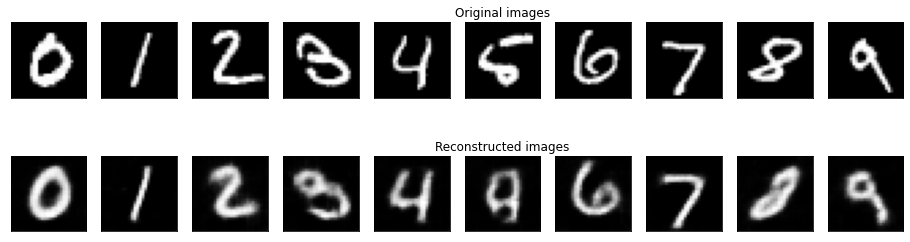

	 partial train loss (single batch): 0.025335
	 partial train loss (single batch): 0.026309
	 partial train loss (single batch): 0.025847
	 partial train loss (single batch): 0.026848
	 partial train loss (single batch): 0.025883
	 partial train loss (single batch): 0.026629
	 partial train loss (single batch): 0.027495
	 partial train loss (single batch): 0.025491
	 partial train loss (single batch): 0.024791
	 partial train loss (single batch): 0.028393
	 partial train loss (single batch): 0.026643
	 partial train loss (single batch): 0.025788
	 partial train loss (single batch): 0.026507
	 partial train loss (single batch): 0.026514
	 partial train loss (single batch): 0.024792
	 partial train loss (single batch): 0.026224
	 partial train loss (single batch): 0.024895
	 partial train loss (single batch): 0.025540
	 partial train loss (single batch): 0.028982
	 partial train loss (single batch): 0.026497
	 partial train loss (single batch): 0.025588
	 partial train loss (single batch

	 partial train loss (single batch): 0.024555
	 partial train loss (single batch): 0.026643
	 partial train loss (single batch): 0.025524
	 partial train loss (single batch): 0.027753
	 partial train loss (single batch): 0.026074
	 partial train loss (single batch): 0.025366
	 partial train loss (single batch): 0.026059
	 partial train loss (single batch): 0.025110

 EPOCH 22/30 	 train loss 0.026281001046299934 	 val loss 0.026764435693621635


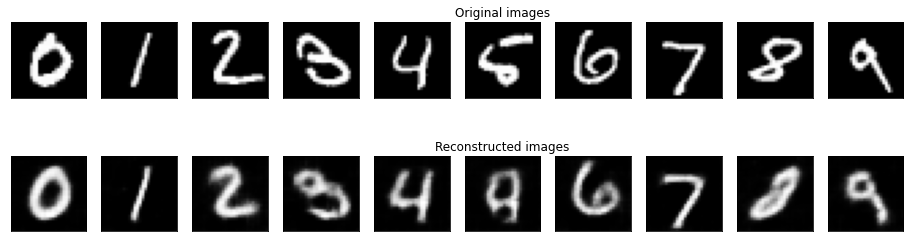

	 partial train loss (single batch): 0.025139
	 partial train loss (single batch): 0.026189
	 partial train loss (single batch): 0.025672
	 partial train loss (single batch): 0.026792
	 partial train loss (single batch): 0.025747
	 partial train loss (single batch): 0.026529
	 partial train loss (single batch): 0.027279
	 partial train loss (single batch): 0.025423
	 partial train loss (single batch): 0.024686
	 partial train loss (single batch): 0.028305
	 partial train loss (single batch): 0.026625
	 partial train loss (single batch): 0.025676
	 partial train loss (single batch): 0.026388
	 partial train loss (single batch): 0.026456
	 partial train loss (single batch): 0.024783
	 partial train loss (single batch): 0.026212
	 partial train loss (single batch): 0.024819
	 partial train loss (single batch): 0.025488
	 partial train loss (single batch): 0.028917
	 partial train loss (single batch): 0.026457
	 partial train loss (single batch): 0.025540
	 partial train loss (single batch

	 partial train loss (single batch): 0.024528
	 partial train loss (single batch): 0.026477
	 partial train loss (single batch): 0.025345
	 partial train loss (single batch): 0.027636
	 partial train loss (single batch): 0.025932
	 partial train loss (single batch): 0.025248
	 partial train loss (single batch): 0.026029
	 partial train loss (single batch): 0.024978

 EPOCH 23/30 	 train loss 0.02618349902331829 	 val loss 0.026676269248127937


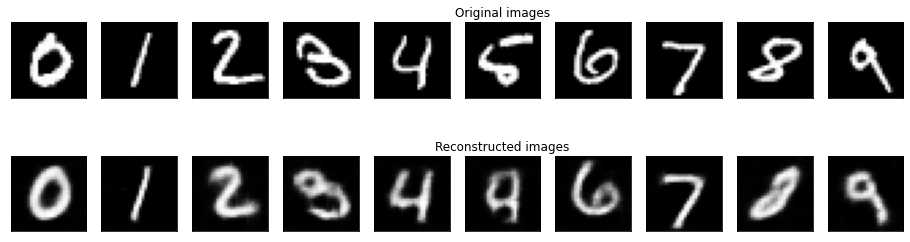

	 partial train loss (single batch): 0.025037
	 partial train loss (single batch): 0.026142
	 partial train loss (single batch): 0.025529
	 partial train loss (single batch): 0.026682
	 partial train loss (single batch): 0.025666
	 partial train loss (single batch): 0.026468
	 partial train loss (single batch): 0.027236
	 partial train loss (single batch): 0.025262
	 partial train loss (single batch): 0.024587
	 partial train loss (single batch): 0.028143
	 partial train loss (single batch): 0.026452
	 partial train loss (single batch): 0.025601
	 partial train loss (single batch): 0.026276
	 partial train loss (single batch): 0.026294
	 partial train loss (single batch): 0.024636
	 partial train loss (single batch): 0.026138
	 partial train loss (single batch): 0.024657
	 partial train loss (single batch): 0.025429
	 partial train loss (single batch): 0.028782
	 partial train loss (single batch): 0.026332
	 partial train loss (single batch): 0.025486
	 partial train loss (single batch

	 partial train loss (single batch): 0.024460
	 partial train loss (single batch): 0.026487
	 partial train loss (single batch): 0.025360
	 partial train loss (single batch): 0.027555
	 partial train loss (single batch): 0.025853
	 partial train loss (single batch): 0.025206
	 partial train loss (single batch): 0.026005
	 partial train loss (single batch): 0.024926

 EPOCH 24/30 	 train loss 0.026107512414455414 	 val loss 0.02657749503850937


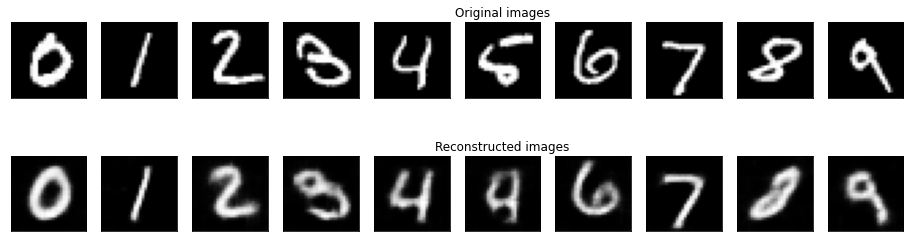

	 partial train loss (single batch): 0.024893
	 partial train loss (single batch): 0.026061
	 partial train loss (single batch): 0.025466
	 partial train loss (single batch): 0.026567
	 partial train loss (single batch): 0.025578
	 partial train loss (single batch): 0.026338
	 partial train loss (single batch): 0.026995
	 partial train loss (single batch): 0.025168
	 partial train loss (single batch): 0.024554
	 partial train loss (single batch): 0.028096
	 partial train loss (single batch): 0.026462
	 partial train loss (single batch): 0.025515
	 partial train loss (single batch): 0.026197
	 partial train loss (single batch): 0.026180
	 partial train loss (single batch): 0.024415
	 partial train loss (single batch): 0.026050
	 partial train loss (single batch): 0.024626
	 partial train loss (single batch): 0.025346
	 partial train loss (single batch): 0.028623
	 partial train loss (single batch): 0.026307
	 partial train loss (single batch): 0.025370
	 partial train loss (single batch

	 partial train loss (single batch): 0.024442
	 partial train loss (single batch): 0.026388
	 partial train loss (single batch): 0.025339
	 partial train loss (single batch): 0.027521
	 partial train loss (single batch): 0.025830
	 partial train loss (single batch): 0.025107
	 partial train loss (single batch): 0.025943
	 partial train loss (single batch): 0.024905

 EPOCH 25/30 	 train loss 0.026018016040325165 	 val loss 0.026583818718791008


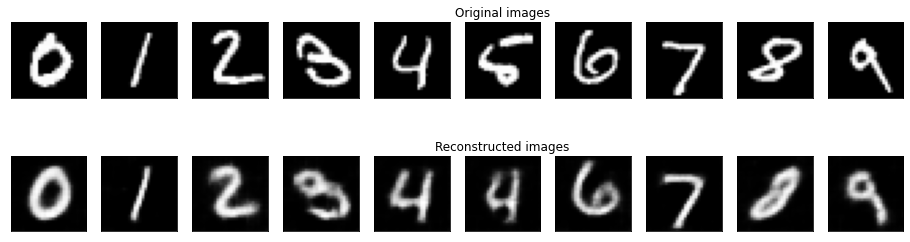

	 partial train loss (single batch): 0.024887
	 partial train loss (single batch): 0.025993
	 partial train loss (single batch): 0.025429
	 partial train loss (single batch): 0.026512
	 partial train loss (single batch): 0.025544
	 partial train loss (single batch): 0.026270
	 partial train loss (single batch): 0.026907
	 partial train loss (single batch): 0.025107
	 partial train loss (single batch): 0.024590
	 partial train loss (single batch): 0.028098
	 partial train loss (single batch): 0.026396
	 partial train loss (single batch): 0.025470
	 partial train loss (single batch): 0.026137
	 partial train loss (single batch): 0.026112
	 partial train loss (single batch): 0.024344
	 partial train loss (single batch): 0.026004
	 partial train loss (single batch): 0.024581
	 partial train loss (single batch): 0.025314
	 partial train loss (single batch): 0.028604
	 partial train loss (single batch): 0.026249
	 partial train loss (single batch): 0.025333
	 partial train loss (single batch

	 partial train loss (single batch): 0.024402
	 partial train loss (single batch): 0.026279
	 partial train loss (single batch): 0.025117
	 partial train loss (single batch): 0.027429
	 partial train loss (single batch): 0.025703
	 partial train loss (single batch): 0.025038
	 partial train loss (single batch): 0.025898
	 partial train loss (single batch): 0.024863

 EPOCH 26/30 	 train loss 0.02595207467675209 	 val loss 0.026473043486475945


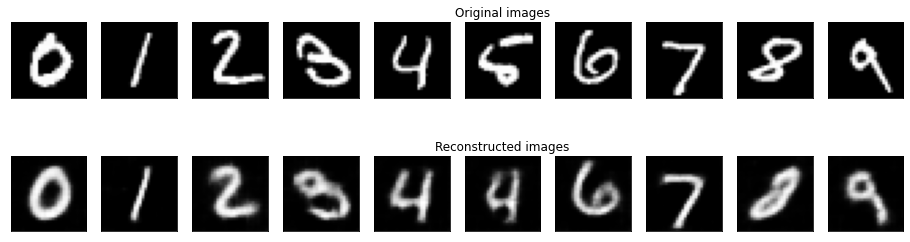

	 partial train loss (single batch): 0.024692
	 partial train loss (single batch): 0.025888
	 partial train loss (single batch): 0.025352
	 partial train loss (single batch): 0.026401
	 partial train loss (single batch): 0.025389
	 partial train loss (single batch): 0.026145
	 partial train loss (single batch): 0.026728
	 partial train loss (single batch): 0.025061
	 partial train loss (single batch): 0.024513
	 partial train loss (single batch): 0.028065
	 partial train loss (single batch): 0.026342
	 partial train loss (single batch): 0.025458
	 partial train loss (single batch): 0.025960
	 partial train loss (single batch): 0.025953
	 partial train loss (single batch): 0.024209
	 partial train loss (single batch): 0.025844
	 partial train loss (single batch): 0.024549
	 partial train loss (single batch): 0.025241
	 partial train loss (single batch): 0.028424
	 partial train loss (single batch): 0.026154
	 partial train loss (single batch): 0.025340
	 partial train loss (single batch

	 partial train loss (single batch): 0.026463
	 partial train loss (single batch): 0.024422
	 partial train loss (single batch): 0.026220
	 partial train loss (single batch): 0.025098
	 partial train loss (single batch): 0.027489
	 partial train loss (single batch): 0.025707
	 partial train loss (single batch): 0.025062
	 partial train loss (single batch): 0.025928
	 partial train loss (single batch): 0.024857

 EPOCH 27/30 	 train loss 0.025884637609124184 	 val loss 0.02650466375052929


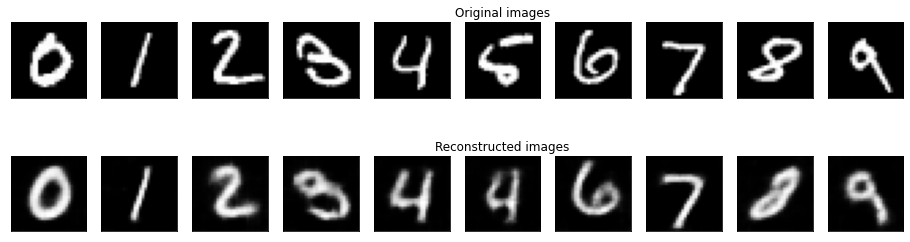

	 partial train loss (single batch): 0.024707
	 partial train loss (single batch): 0.025817
	 partial train loss (single batch): 0.025364
	 partial train loss (single batch): 0.026433
	 partial train loss (single batch): 0.025396
	 partial train loss (single batch): 0.026191
	 partial train loss (single batch): 0.026787
	 partial train loss (single batch): 0.025056
	 partial train loss (single batch): 0.024541
	 partial train loss (single batch): 0.027979
	 partial train loss (single batch): 0.026276
	 partial train loss (single batch): 0.025394
	 partial train loss (single batch): 0.025955
	 partial train loss (single batch): 0.025942
	 partial train loss (single batch): 0.024202
	 partial train loss (single batch): 0.025918
	 partial train loss (single batch): 0.024433
	 partial train loss (single batch): 0.025162
	 partial train loss (single batch): 0.028332
	 partial train loss (single batch): 0.026151
	 partial train loss (single batch): 0.025199
	 partial train loss (single batch

	 partial train loss (single batch): 0.024297
	 partial train loss (single batch): 0.026155
	 partial train loss (single batch): 0.025001
	 partial train loss (single batch): 0.027336
	 partial train loss (single batch): 0.025615
	 partial train loss (single batch): 0.024889
	 partial train loss (single batch): 0.025772
	 partial train loss (single batch): 0.024785

 EPOCH 28/30 	 train loss 0.025833377614617348 	 val loss 0.026413552463054657


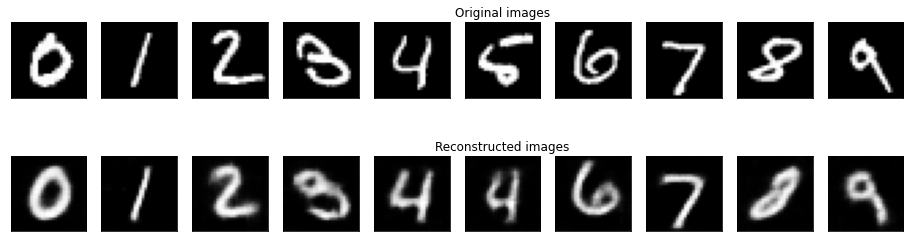

	 partial train loss (single batch): 0.024632
	 partial train loss (single batch): 0.025764
	 partial train loss (single batch): 0.025305
	 partial train loss (single batch): 0.026329
	 partial train loss (single batch): 0.025276
	 partial train loss (single batch): 0.026056
	 partial train loss (single batch): 0.026546
	 partial train loss (single batch): 0.024956
	 partial train loss (single batch): 0.024374
	 partial train loss (single batch): 0.027862
	 partial train loss (single batch): 0.026236
	 partial train loss (single batch): 0.025309
	 partial train loss (single batch): 0.025960
	 partial train loss (single batch): 0.025912
	 partial train loss (single batch): 0.024171
	 partial train loss (single batch): 0.025787
	 partial train loss (single batch): 0.024389
	 partial train loss (single batch): 0.025053
	 partial train loss (single batch): 0.028206
	 partial train loss (single batch): 0.026045
	 partial train loss (single batch): 0.025091
	 partial train loss (single batch

	 partial train loss (single batch): 0.024322
	 partial train loss (single batch): 0.026117
	 partial train loss (single batch): 0.025029
	 partial train loss (single batch): 0.027227
	 partial train loss (single batch): 0.025572
	 partial train loss (single batch): 0.024855
	 partial train loss (single batch): 0.025693
	 partial train loss (single batch): 0.024716

 EPOCH 29/30 	 train loss 0.025773383677005768 	 val loss 0.026388201862573624


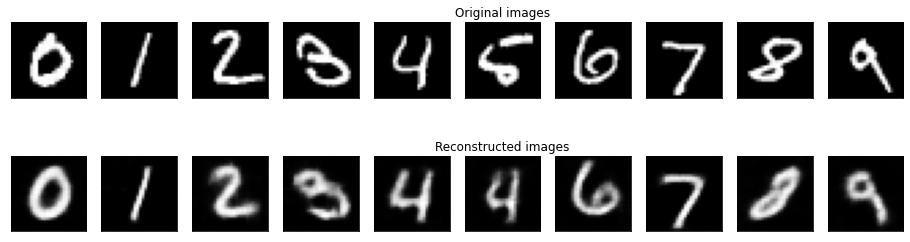

	 partial train loss (single batch): 0.024565
	 partial train loss (single batch): 0.025692
	 partial train loss (single batch): 0.025226
	 partial train loss (single batch): 0.026231
	 partial train loss (single batch): 0.025234
	 partial train loss (single batch): 0.025995
	 partial train loss (single batch): 0.026440
	 partial train loss (single batch): 0.024900
	 partial train loss (single batch): 0.024388
	 partial train loss (single batch): 0.027800
	 partial train loss (single batch): 0.026194
	 partial train loss (single batch): 0.025301
	 partial train loss (single batch): 0.025891
	 partial train loss (single batch): 0.025852
	 partial train loss (single batch): 0.024121
	 partial train loss (single batch): 0.025762
	 partial train loss (single batch): 0.024370
	 partial train loss (single batch): 0.025027
	 partial train loss (single batch): 0.028074
	 partial train loss (single batch): 0.026011
	 partial train loss (single batch): 0.025015
	 partial train loss (single batch

	 partial train loss (single batch): 0.024274
	 partial train loss (single batch): 0.026077
	 partial train loss (single batch): 0.025001
	 partial train loss (single batch): 0.027131
	 partial train loss (single batch): 0.025536
	 partial train loss (single batch): 0.024820
	 partial train loss (single batch): 0.025654
	 partial train loss (single batch): 0.024602

 EPOCH 30/30 	 train loss 0.02572176791727543 	 val loss 0.02632257342338562


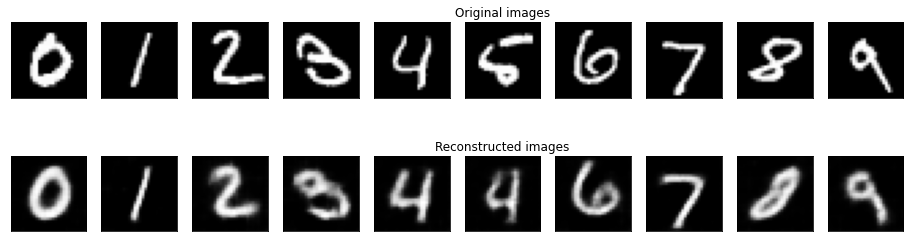

In [10]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [15]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02632257342338562

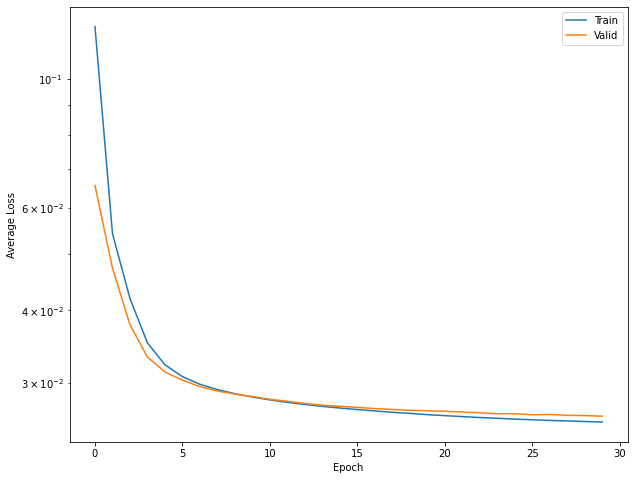

In [16]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([-0.1675,  0.3017,  0.1985,  0.0670])
tensor([0.7573, 0.6835, 0.6231, 0.6613])


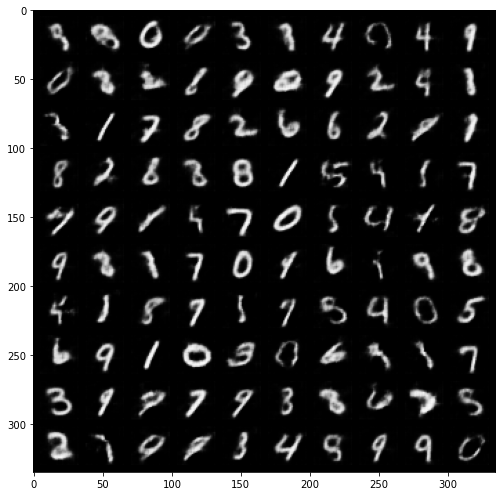

In [17]:

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()


In [18]:

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples



NameError: name 'tqdm' is not defined

In [14]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)


ModuleNotFoundError: No module named 'plotly'

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()